# Per Study Analysis
---
Examine model performance for each study instead of aggregated over all samples

In [1]:
import pandas
from plotnine import *
import plotnine

plotnine.options.figure_size = (8,6)

In [2]:
%%bash
PLIER_OUT='../data/study_plier'
mkdir -p $PLIER_OUT

## Subset Studies

From the set of all labeled data (output by download_categorized_data.ipynb), extract the subset corresponding to blood (UBERON:0000178).

## Train PLIER

Train PLIER for dimensionality reduction on a fraction of the studies with blood samples

In [3]:
%%bash
PLIER_OUT='../data/study_plier'

# K_VALS stores the different values of k (number of PCs) to be used by PLIER.
K_VALS=(50)

# Pass each K_value to run_plier and execute the different instances in paralell
# The code before the pipe prints all the values of K on its own line
# The code after the pipe tells bash to run run_plier.R once for each value of K,
# But using no more than NUM_PROCESSES threads to do so
printf "../data/plier_healthy.tsv ../data/plier_disease.tsv $PLIER_OUT -k %s" \
       "${K_VALS[0]}" | xargs -n 5 --max-procs=4 Rscript ../brdnet/run_plier.R
       
python ../brdnet/create_identity_matrix_df.py $PLIER_OUT/plier_${K_VALS[0]}_Z.tsv $PLIER_OUT/plier_all_Z.tsv

[1] 132.6737
[1] "L2 is set to 132.673724842568"
[1] "L1 is set to 66.336862421284"



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: PLIER
Loading required package: RColorBrewer
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: pheatmap
Loading required package: glmnet
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-18

Loading required package: knitr
Loading required package: rsvd
Loading required package: qvalue
Selecting common genes: 6605
Removing 4 pathways with too few genes
Computing SVD
Using rsvd
Done
errorY (SVD based:best possible) = 0.4032
Updating L3, current fraction= 0, target=0.7
0 positive columns at L3=0.5
0 positive columns at L3=0.250001
0 positive columns at L3=0.125001
7 positive columns at L3=0.062501
26 positive columns at L3=0.03125

## Train Discriminator Model

In [31]:
%%bash
PLIER_OUT='../data/study_plier'

python ../brdnet/evaluate_models.py $PLIER_OUT ../data/classifier_healthy.tsv \
                                    ../data/classifier_disease.tsv \
                                    --out_path ../results/eval_results.csv\
                                    --study_out_path ../results/study_eval_results.csv\
                                    --epochs 400

Model: IForest
Z_file: ../data/study_plier/plier_all_Z.tsv
seed: 0


Model: OCSVM
Z_file: ../data/study_plier/plier_all_Z.tsv
seed: 0


Model: LogisticRegression
Z_file: ../data/study_plier/plier_all_Z.tsv
seed: 0


12/12 [==============================] - 0s 105us/sample - loss: 20.8291 - acc: 0.5833 - auc_4: 0.0000e+00 - auc_5: 1.0000
Model: MLP
Z_file: ../data/study_plier/plier_all_Z.tsv
seed: 0


12/12 [==============================] - 0s 105us/sample - loss: 5.0776 - acc: 0.7500 - auc_10: 0.0000e+00 - auc_11: 1.0000
Model: TenLayerNet
Z_file: ../data/study_plier/plier_all_Z.tsv
seed: 0


12/12 [==============================] - 0s 162us/sample - loss: 0.6851 - acc: 0.6667 - auc_16: 0.0000e+00 - auc_17: 1.0000
Model: IForest
Z_file: ../data/study_plier/plier_all_Z.tsv
seed: 1


Model: OCSVM
Z_file: ../data/study_plier/plier_all_Z.tsv
seed: 1


Model: LogisticRegression
Z_file: ../data/study_plier/plier_all_Z.tsv
seed: 1


15/15 [==============================] - 0s 183us/sample - 

/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-pack

## Load the dataframe generated by evaluate_models.py

In [32]:
result_df = pandas.read_csv('../results/model_eval_study_results.csv', index_col=0)

result_df['acc_over_baseline'] = result_df['val_acc'] - result_df['val_baseline']

result_df.head()

,Model,Study,LR,Seed,val_acc,val_auroc,val_aupr,val_baseline,lv_count,acc_over_baseline
0,IForest,SRP065491,0.00001,0,0.000000,NaN,NaN,1.000000,100,-1.000000
1,IForest,SRP052056,0.00001,0,0.681818,0.555556,0.865112,0.818182,100,-0.136364
2,IForest,SRP056969,0.00001,0,0.650000,NaN,NaN,1.000000,100,-0.350000
3,IForest,SRP065559,0.00001,0,1.000000,NaN,NaN,1.000000,100,0.000000
4,IForest,SRP026387,0.00001,0,0.384615,NaN,NaN,1.000000,100,-0.615385


In [33]:
one_class_df = result_df[result_df['val_baseline'] == 1]
two_class_df = result_df[result_df['val_baseline'] != 1]

one_class_df.head()

,Model,Study,LR,Seed,val_acc,val_auroc,val_aupr,val_baseline,lv_count,acc_over_baseline
0,IForest,SRP065491,0.00001,0,0.000000,NaN,NaN,1.0,100,-1.000000
2,IForest,SRP056969,0.00001,0,0.650000,NaN,NaN,1.0,100,-0.350000
3,IForest,SRP065559,0.00001,0,1.000000,NaN,NaN,1.0,100,0.000000
4,IForest,SRP026387,0.00001,0,0.384615,NaN,NaN,1.0,100,-0.615385
5,IForest,ERP003613,0.00001,0,0.419355,NaN,NaN,1.0,100,-0.580645


## Calculate descriptive statistics

In [34]:
for group, df in result_df.groupby(['Model']):
    print(group, df['val_acc'].mean())

IForest 0.4180499736344993
LogisticRegression 0.5552985923183313
MLP 0.5878785249686416
OCSVM 0.4016671003275642
TenLayerNet 0.5853798332021347


In [35]:
for group, df in one_class_df.groupby(['Model']):
    print(group, df['val_acc'].mean())

IForest 0.3718007771991211
LogisticRegression 0.5824920251233551
MLP 0.6089236626879984
OCSVM 0.3391877058177827
TenLayerNet 0.6011062422861566


In [36]:
for group, df in two_class_df.groupby(['Model']):
    print(group, df['val_acc'].mean())

IForest 0.5225984052787415
LogisticRegression 0.4938265891288114
MLP 0.5403050250621055
OCSVM 0.5429046397777154
TenLayerNet 0.5502522511023972


In [37]:
for group, df in two_class_df.groupby(['Model']):
    print(group, df['val_auroc'].mean())

IForest 0.5085868945246002
LogisticRegression 0.5104903633851863
MLP 0.5594819216958938
OCSVM 0.5222116814995268
TenLayerNet 0.5799491100724617


### How does raw gene expression perform?

In [38]:
raw_expression_df = result_df[result_df['lv_count'] == 6605]

for group, df in raw_expression_df.groupby(['Model']):
    print(group, df['val_acc'].mean())

IForest 0.4622236074877185
LogisticRegression 0.5790574822812936
MLP 0.585183573144495
OCSVM 0.41724032272378325
TenLayerNet 0.5919180199559918


### Conclusion
The supervised models tend to perform slightly better than a coin flip

## Plot performance of TenLayerNet
---
The ten layer neural network had one of the highest mean accuracies across studies, so we'll plot it to find the distribution of its accuracy scores

/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


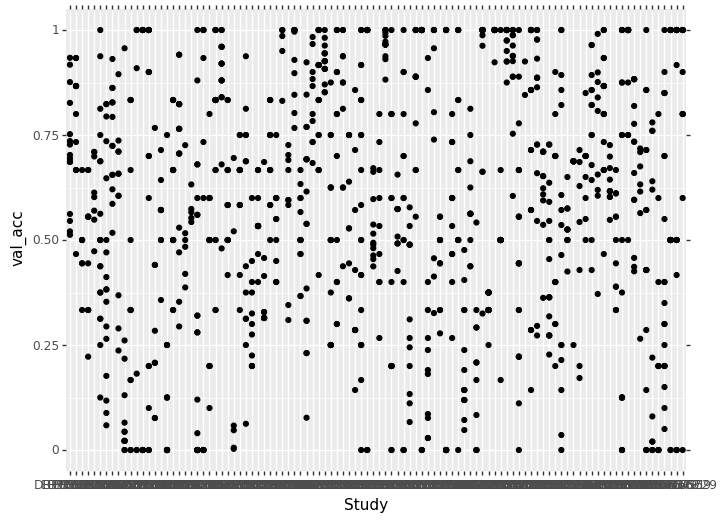

<ggplot: (8782102031701)>

In [39]:
ggplot(result_df[result_df['Model'] == 'TenLayerNet'], aes(x='Study', y='val_acc')) +\
geom_point()

#### two_class_df
Note that two_class_df is used here instead of the full results_df. This is because the baseline accuracy for a study with one class will always be 1, which will make its distribution identical to the one class points in the previous plot.

/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


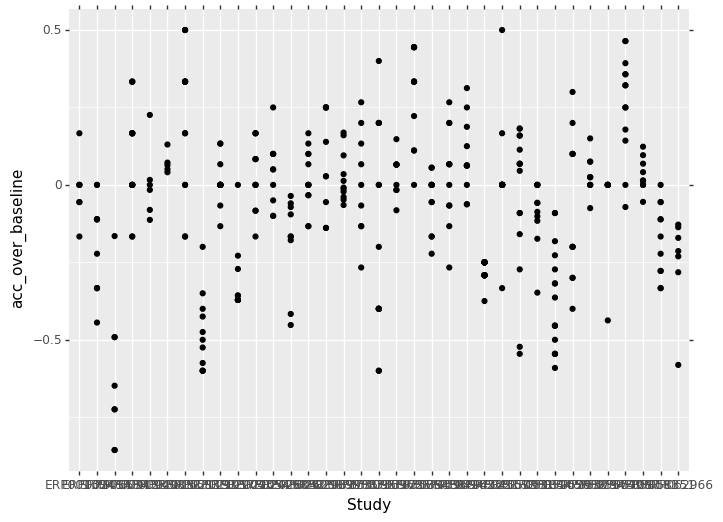

<ggplot: (-9223363254735391870)>

In [40]:
ggplot(two_class_df[two_class_df['Model'] == 'TenLayerNet'], aes(x='Study', y='acc_over_baseline')) +\
geom_point()

### Conclusions
There is a huge amount of variance in the model's predictive performance between training sets, even when evaluating the model on the same study.

## Compare to results aggregated across all samples
---
The previous results aggregate at a study level, while the following results aggregate at a sample level to see if there is a difference

In [41]:
samples_df = pandas.read_csv('../results/model_eval_results.csv', index_col=0)
samples_df.head()

,Model,LR,Seed,val_acc,val_auroc,val_aupr,val_baseline,lv_count
0,IForest,0.00001,0,0.000000,0.444444,0.615912,0.5874,100
1,OCSVM,0.00001,0,0.000000,0.500000,0.625000,0.5874,100
2,LogisticRegression,0.00001,0,0.477374,0.498723,0.412432,0.5874,100
3,MLP,0.00001,0,0.513753,0.584219,0.471741,0.5874,100
4,TenLayerNet,0.00001,0,0.449867,0.625267,0.655625,0.5874,100


In [42]:
samples_df.groupby('Model')['val_acc'].mean()

Model
IForest               0.435377
LogisticRegression    0.604462
MLP                   0.629567
OCSVM                 0.335436
TenLayerNet           0.620876
Name: val_acc, dtype: float64

In [43]:
raw_expression_df = samples_df[samples_df['lv_count'] == 6605]
raw_expression_df.groupby('Model')['val_acc'].mean()

Model
IForest               0.530704
LogisticRegression    0.591908
MLP                   0.612515
OCSVM                 0.299784
TenLayerNet           0.607885
Name: val_acc, dtype: float64

### Conclusion
The results aggregated samplewise perform better than average across studies, implying that bigger studies have higher accuracies on average than smaller ones. It is possible that bigger studies are more likely to correspond to well-studied diseases, leading to data leakage between the training and testing set.